In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [46]:
# Import data

dataset = 'ftse' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('../Data/%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('../Data/%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('../Data/%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('../Data/%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [48]:
dim

21

In [29]:
node_descr = np.delete(nodes_descr, 1, 1)
node_labels = {}
for node in nodes_descr:
    node_labels[node[0]] = node[2]

In [3]:
print("num examples: %d, matrix dim: %d" % (num_examples, dim))

num examples: 120, matrix dim: 19


In [4]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def coloring_score(G, coloring):
    count = 0
    for e in G.edges():
        v1, v2 = e
        if coloring[v1] == coloring[v2]:
            count += 1
        
        return count/G.number_of_edges()

In [74]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[50, :, :].copy()
        
corr_mat[(corr_mat > -1*0.3) & (corr_mat < 0.3)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

In [75]:
density

0.5619047619047619

/Users/angadkalra/Projects/dwave_ocean/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


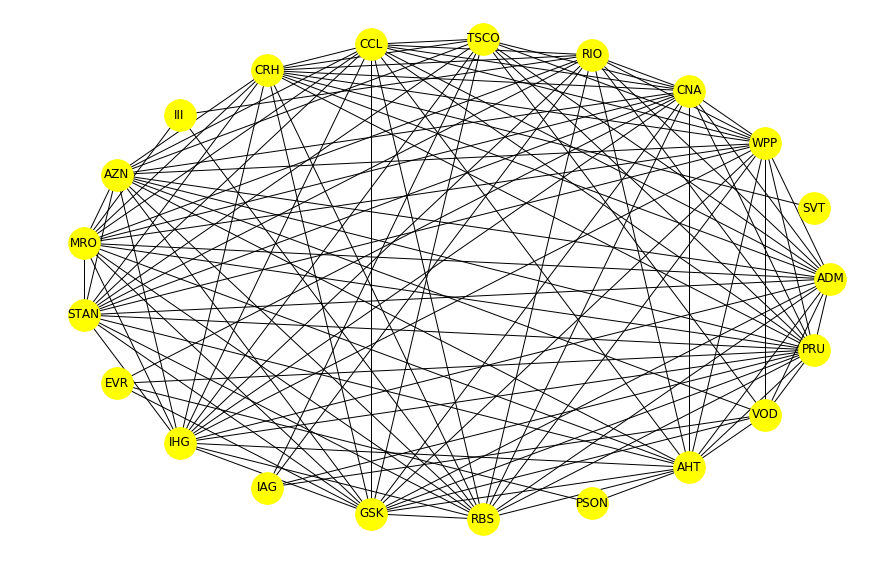

In [76]:
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, node_color="yellow")
fig.savefig('../ReportFiguresPlots/GraphColor/GraphVisual/%s_before.png'%(dataset))

In [77]:
coloring = dnx.min_vertex_coloring(G, sampler)
num_colors = np.max(list(coloring.values()))

In [78]:
assert num_colors > 0 and num_colors <= get_max_deg(G)

In [79]:
get_max_deg(G)

17

In [80]:
dnx.is_vertex_coloring(G, coloring)

True

In [81]:
coloring

{'ADM': 0,
 'AHT': 12,
 'AZN': 11,
 'CCL': 5,
 'CNA': 3,
 'CRH': 1,
 'EVR': 6,
 'GSK': 13,
 'IAG': 6,
 'IHG': 9,
 'III': 5,
 'MRO': 7,
 'PRU': 10,
 'PSON': 4,
 'RBS': 6,
 'RIO': 4,
 'STAN': 8,
 'SVT': 7,
 'TSCO': 7,
 'VOD': 5,
 'WPP': 2}

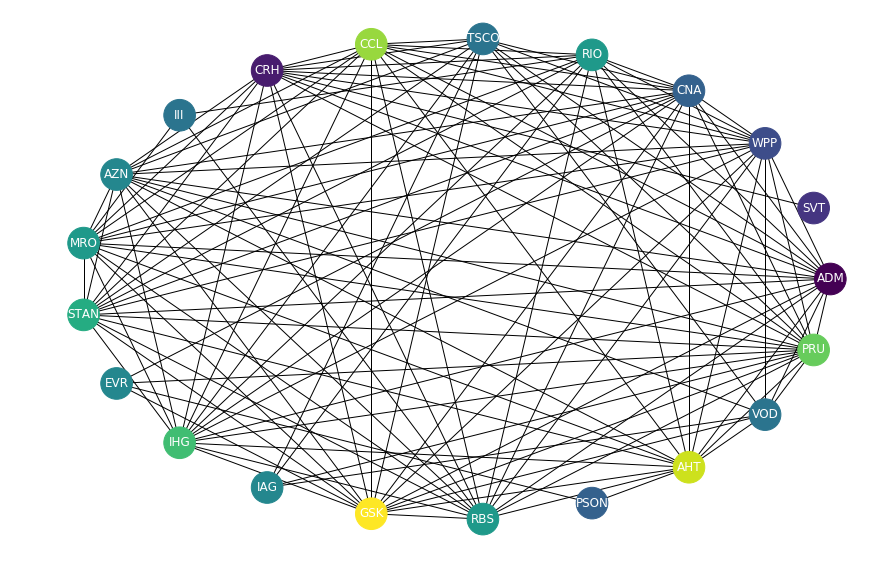

In [82]:
fig,ax = plt.subplots(figsize=(15,10))
nx.draw_shell(G, ax=ax, with_labels=True, node_size=1000, 
                 node_color=list(coloring.values()), font_color="white")
fig.savefig('../ReportFiguresPlots/GraphColor/GraphVisual/%s_after.png'%(dataset))

In [26]:
# Plot graph density for each threshold. 

thresh_array = []
density_distr = []

for i in np.arange(0.1, 1, 0.1):
    density_array = []
    for j in range(1, int(num_examples/5)):
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        density_array.append(density)
    
    density_distr.append(density_array)

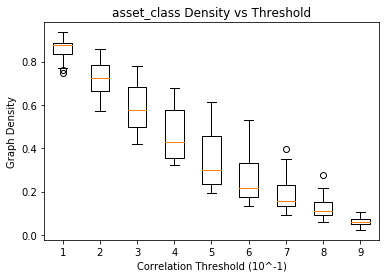

In [27]:
plt.boxplot(density_distr)
plt.ylabel("Graph Density")
plt.xlabel("Correlation Threshold (10^-1)")
plt.title("%s Density vs Threshold" % (dataset))
plt.show()

In [29]:
# Create graph for each date and calculate best coloring using quantum computer. 

coloring_array = []
valid_coloring_array = []
num_colors_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.5, 1, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: 
            print("count: %d" % (count))
            
        try:
            opt_coloring = {}
            min_colors = dim
            
            for k in range(10):
                coloring = dnx.min_vertex_coloring(G, sampler)
                num_colors = np.max(list(coloring.values())) + 1
                valid_coloring = dnx.is_vertex_coloring(G, coloring)
                
                if valid_coloring and num_colors < min_colors:
                    opt_coloring = coloring
                    min_colors = num_colors
            
            if opt_coloring == {}:
                raise Exception
                
        except Exception as err:
            print(err)
            print("Error on matrix %d with threshold %f" % (j*5, i))
        else:
            
            coloring_array.append(opt_coloring)
            num_colors_array.append(min_colors)
            valid_coloring_array.append(valid_coloring)
            
            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])
        

no embedding found
Error on matrix 5 with threshold 0.500000
no embedding found
Error on matrix 10 with threshold 0.500000
'USO'
Error on matrix 15 with threshold 0.500000
no embedding found
Error on matrix 20 with threshold 0.500000
no embedding found
Error on matrix 25 with threshold 0.500000
'TIP'
Error on matrix 35 with threshold 0.500000
'VEU'
Error on matrix 40 with threshold 0.500000
count: 10
'TLT'
Error on matrix 55 with threshold 0.500000
'USRT'
Error on matrix 60 with threshold 0.500000


/home/angad/Projects/quantcomp/ocean/lib/python3.6/site-packages/dwave_networkx/algorithms/coloring.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  bound = ceil(max(eigenvalues(nx.to_numpy_matrix(G))))


'SHY'
Error on matrix 70 with threshold 0.500000
Unknown exception
Error on matrix 75 with threshold 0.500000
'VEU'
Error on matrix 85 with threshold 0.500000
'VTI'
Error on matrix 90 with threshold 0.500000
count: 20
'VB'
Error on matrix 100 with threshold 0.500000
'VO'
Error on matrix 105 with threshold 0.500000
'USRT'
Error on matrix 110 with threshold 0.500000
'VTI'
Error on matrix 115 with threshold 0.500000
'VB'
Error on matrix 5 with threshold 0.600000
no embedding found
Error on matrix 10 with threshold 0.600000
'RWR'
Error on matrix 15 with threshold 0.600000
'VB'
Error on matrix 20 with threshold 0.600000
no embedding found
Error on matrix 25 with threshold 0.600000
'DBE'
Error on matrix 30 with threshold 0.600000
count: 30
no embedding found
Error on matrix 40 with threshold 0.600000
'USRT'
Error on matrix 50 with threshold 0.600000
Unknown exception
Error on matrix 65 with threshold 0.600000
Unknown exception
Error on matrix 70 with threshold 0.600000
Unknown exception
Erro

In [30]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

In [31]:
len(date_array)

50

In [32]:
# Create Pandas DataFrame for quantum results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array}).to_csv("grphcolor_quant_%s_res.csv" % (dataset))

In [33]:
# Run classical graph coloring algm on the matrices that ran successfully above
from networkx.algorithms.coloring import greedy_color

coloring_array = []
valid_coloring_array = []
num_colors_array = []
density_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        coloring = greedy_color(G, strategy='independent_set')
        valid_coloring = dnx.is_vertex_coloring(G, coloring)
    except Exception as err:
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        num_colors = np.max(list(coloring.values())) + 1

        coloring_array.append(coloring)
        num_colors_array.append(num_colors)
        valid_coloring_array.append(valid_coloring)

        density_array.append(density)


In [34]:
assert len(coloring_array) == len(density_array) ==  len(num_colors_array) == len(valid_coloring_array)

In [35]:
len(coloring_array)

50

In [36]:
# Create Pandas DataFrame for classical results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array}).to_csv("grphcolor_class_%s_res.csv" % (dataset))

In [84]:
# Compare classical vs quantum
quant_res_df = pd.read_csv("grphcolor_quant_%s_res.csv" % (dataset))
class_res_df = pd.read_csv("grphcolor_class_%s_res.csv" % (dataset))

In [89]:
assert quant_res_df["date"].equals(class_res_df["date"])

In [113]:
quant_res_df["threshold"].unique()

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [111]:
quant_res_df.loc[quant_res_df['threshold'] == 0.6].shape[0]

0

In [112]:
for value in quant_res_df["threshold"].unique():
    count = quant_res_df.loc[quant_res_df['threshold'] == value].shape[0]
    print(count)

9
14
14
12
18
16
17


In [103]:
quant_res_df.loc[quant_res_df["threshold"] == 0.8]

,Unnamed: 0,date,threshold,density,coloring,num_colors,valid_coloring


In [98]:
quant_res = quant_res_df.loc[quant_res_df["threshold"] == 0.8]
class_res = class_res_df.loc[class_res_df["threshold"] == 0.8]

In [99]:
class_res.shape

(0, 7)

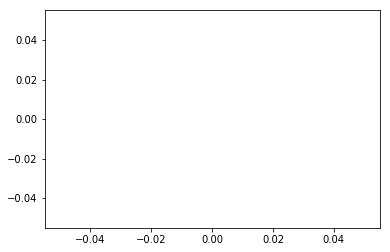

In [81]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(quant_res["date"], quant_res["num_colors"], 'r--')
plt.plot(class_res["date"], class_res['num_colors'], 'b--')

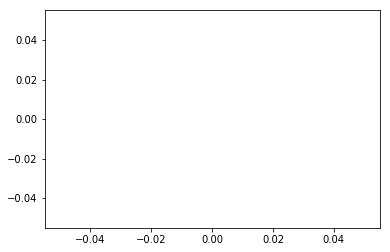

In [82]:
plt.figure(2)
plt.plot(quant_res["date"], quant_res["density"], 'r')
plt.plot(class_res["date"], class_res["density"], 'b')

In [83]:
quant_res

,Unnamed: 0,date,threshold,density,coloring,num_colors,valid_coloring


IndexError: index out of bounds

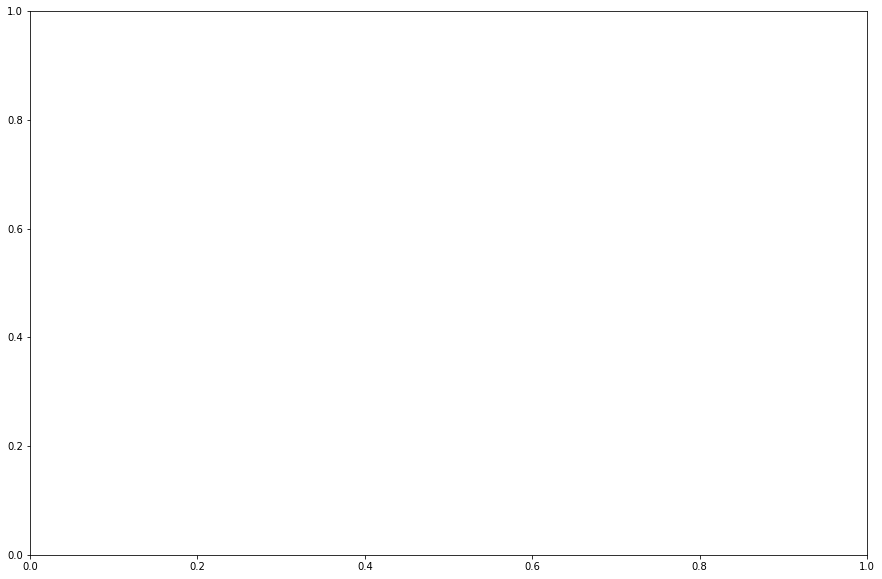

In [75]:
fig, ax = plt.subplots(figsize=(15, 10))

date = quant_res["date"][42]
idx = dates.tolist().index(date)

corr_mat = corr_tensor[idx, :, :].copy()
corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

nx.draw_networkx(G, pos=nx.spring_layout(G), font_size=14, node_color='w', ax = ax)